# ADA Project : Milestone 2

## Preparation

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from utils import *

### Conversion : txt to csv

In [2]:
# Require extensive amount of RAM (a bit less than 32Gb)
do_conversion = False
if do_conversion:
    ratings_text_to_csv("./data/BeerAdvocate/ratings.txt")
    ratings_text_to_csv("./data/RateBeer/ratings.txt")

### Load data

In [3]:
# BeerAdvocate (BA)
beers_BA, breweries_BA, users_BA, ratings_BA = load_data("BA")

In [4]:
# RateBeer (RB)
beers_RB, breweries_RB, users_RB, ratings_RB = load_data("RB")

In [2]:
# Matched Dataset (MD)
beers_MD, breweries_MD, users_MD, users_approx_MD, ratings_MD = load_data("MD")

c:\Users\Mathi\OneDrive\Bureau\OneDrive\etudes\epfl\MA1\ADA\Project\ada-2023-project-dada\utils.py:21: DtypeWarning: Columns (0,1,2,3,4,5,8,10,11,12,13,15,16,17,18,19,20,23,25,26,27,29,30,31,32) have mixed types. Specify dtype option on import or set low_memory=False.
  beers_MD = pd.read_table("./data/matched_beer_data/beers.csv", sep=",")
c:\Users\Mathi\OneDrive\Bureau\OneDrive\etudes\epfl\MA1\ADA\Project\ada-2023-project-dada\utils.py:25: DtypeWarning: Columns (0,1,2,3,5,7,8,9,10,11,13,17,18,19,20,22,24,25,26,27,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  ratings_MD = pd.read_table("./data/matched_beer_data/ratings.csv", sep=",")


### Populate and merge data from BA and RB

In [6]:
# Require extensive amount of RAM (>20Gb)
do_populate_merge = False
if do_populate_merge:
    
    # Populate ratings with info from users, breweries and beers
    ratings_populated_BA = populate_ratings(ratings_BA, users_BA, breweries_BA, beers_BA, "BA")
    ratings_populated_RB = populate_ratings(ratings_RB, users_RB, breweries_RB, beers_RB, "RB")

    # Merge populated ratings
    merged_ratings_path = "./data/ratings_BA_RB.csv"
    ratings_mixed = merge_populated_ratings(ratings_populated_BA, ratings_populated_RB, merged_ratings_path)

    # Save subsample of rating (easier to handle on laptops)
    merged_ratings_sample_path = "./data/ratings_BA_RB_sample.csv"
    save_subsample(dataframe=ratings_mixed, save_path = merged_ratings_sample_path, frac=0.1, random_state=0)

### Load populated merged ratings

In [5]:
# ratings_mixed = pd.read_table("./data/ratings_BA_RB.csv", sep=",")
ratings_mixed_sample = pd.read_table("./data/ratings_BA_RB_sample.csv", sep=",")

## Analysis

### Linear regression on subset of reviews
Function that takes a subset of ratings and columns of interest as input and returns a Linear Regresion results

In [3]:
def get_LR(data, columns):
    # create formula and normalize data
    columns=list(columns)
    formula = 'rating ~ ' + columns[0]
    columns.append('rating')  # add rating for the linear regression
    for idx, el in enumerate(columns):
        if len(columns) - 1 > idx > 0:  # add feature to formula
            formula += ' + ' + el
        data[el] = (data[el] - data[el].mean())/data[el].std()  # standardization

    data_to_process = data[columns].dropna().sample(frac=1)  # create a subset with the columns of interest and shuffle it
    
    # create the model and fit it to the dataset
    mod = smf.ols(formula=formula, data=data_to_process)
    np.random.seed(2)
    res = mod.fit()
    return res

### Linear regression on the full set

- beer_name : name of beer (string)
- beer_id: int
- style: string (categorical)
- abv: float - "alcool by volume"
- nbr_ratings, nbr_reviews, avg, ba_score, bros_score, avg_computed, zscore, overall_score, style_score, nbr_matched_valid_ratings, avg_matched_valid_ratings, joined,    -> CA DEGAGE
- brewery_name : string
- brewery_id : int
- brewery_location: string
- nbr_beers : int
- date : int nb_sec from 01.01.1970
- user_name: string
- user_id : int
- user_location : string
- appearance: categorical
- aroma : float
- palate : float
- taste: float
- taste: float
- overall: float
- rating: float
- text: string
- review: bool
- dataset: categorical


In [6]:
print('Initial columns:\n', ratings_mixed_sample.columns)
columns_of_interest = ["appearance",  "aroma",  "palate",  "taste",  "overall"]
print('\n==============\n')
print('Chosen columns for linear regression are :\n', columns_of_interest)
res = get_LR(ratings_mixed_sample, columns_of_interest)

print('\n==============\n')
print('Results of the linear regression:\n')
print(res.summary())

Initial columns:
 Index(['beer_name', 'beer_id', 'style', 'abv', 'nbr_ratings', 'nbr_reviews',
       'avg', 'ba_score', 'bros_score', 'avg_computed', 'zscore',
       'overall_score', 'style_score', 'nbr_matched_valid_ratings',
       'avg_matched_valid_ratings', 'joined', 'brewery_name', 'brewery_id',
       'brewery_location', 'nbr_beers', 'date', 'user_name', 'user_id',
       'user_location', 'appearance', 'aroma', 'palate', 'taste', 'overall',
       'rating', 'text', 'review', 'dataset'],
      dtype='object')


Chosen columns for linear regression are :
 ['appearance', 'aroma', 'palate', 'taste', 'overall']


Results of the linear regression:

                            OLS Regression Results                            
Dep. Variable:                 rating   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                 9.305e+05
Date:                Fri

In [7]:
print('Let\' now sort the coefficients by absolute impact on the rating:')
print(pd.DataFrame(res.params).sort_values(0, ascending=False, key=abs).to_string(index=True, header=False))

Let' now sort the coefficients by absolute impact on the rating:
overall    -0.692640
taste       0.524010
palate      0.495072
aroma       0.297362
appearance  0.242650
Intercept  -0.109322


Params statistics user_location-wise

In [8]:
# Keep only reviews where user_location has at least 1000 reviews (Arbitrary)
ratings_mixed_1000 = ratings_mixed_sample[ratings_mixed_sample.groupby('user_location')['user_location'].transform('size') > 1000]
countries = ratings_mixed_1000.user_location.unique()
param_df = res.params.copy()

# Analysis of LR parameters among countries
for country in countries:
    country_df = ratings_mixed_1000.loc[ratings_mixed_1000['user_location']==country]
    res = get_LR(country_df, columns_of_interest)
    param_df = pd.concat((param_df, res.params.copy()), axis=1)

# Params per country
param_df.T.describe()

C:\Users\Mathi\AppData\Local\Temp\ipykernel_14972\2986875281.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[el] = (data[el] - data[el].mean())/data[el].std()  # standardization
C:\Users\Mathi\AppData\Local\Temp\ipykernel_14972\2986875281.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[el] = (data[el] - data[el].mean())/data[el].std()  # standardization
C:\Users\Mathi\AppData\Local\Temp\ipykernel_14972\2986875281.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sli

,Intercept,appearance,aroma,palate,taste,overall
count,86.000000,86.000000,86.000000,86.000000,86.000000,86.000000
mean,-0.051464,0.217943,0.287686,0.428347,0.509937,-0.535136
std,0.038760,0.043525,0.063864,0.103916,0.186162,0.438099
min,-0.126151,0.108655,0.146345,0.117728,0.084489,-1.243499
25%,-0.086810,0.199150,0.239292,0.403677,0.355558,-0.880280
50%,-0.045389,0.222794,0.286882,0.458905,0.511515,-0.680498
75%,-0.017075,0.246879,0.327829,0.490581,0.669137,-0.186743
max,0.031489,0.315311,0.430110,0.621659,0.913590,0.452956


### Results
From what we can see of this preliminary analysis, some features are having almost 3 times the influence of others on the rating.
Moreover, the R-squared of the fitted model is **0.796** which means that the regression explains roughly 80% of the variation in the variables which is indicating that this simple model alreay fit quite well the data. In the future of this project, we plan to try more complex architectures in order to get the most accurate representation of the impact of each variable.

Let now see if this influence stays constant geographically..

### Number of review per day using rolling average

In [ ]:


# Assuming the file is named 'beer_ratings.csv' and is located in the same directory as your script.
# Read the CSV file
BA_NR_RW_DAY=ratings_BA
# Convert the Unix time to a datetime object, assuming the 'date' column is Unix time in seconds
BA_NR_RW_DAY['date'] = pd.to_datetime(BA_NR_RW_DAY['date'], unit='s')

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later
BA_NR_RW_DAY_WW = BA_NR_RW_DAY[(BA_NR_RW_DAY['date'] >= start_date) & (BA_NR_RW_DAY['date'] <= end_date)]


In [ ]:
# Group by the date and count the reviews
def plot_rolling(df, window=7):
    daily_reviews = df.groupby(df['date'].dt.date).size()
    print(daily_reviews)
    # Calculate the moving average with a window size of 7 to remove weeks days
    rolling = daily_reviews.rolling(window=window, center=True)
    rolling_average = rolling.mean()
    
    # Plot the rolling average
    plt.figure(figsize=(14, 7))
    rolling_average.plot(title='Number of Reviews Per Day Over One Year')
    
    # Add labels and grid
    plt.xlabel('Date')
    plt.ylabel('Average Number of Reviews')
    plt.grid(True)
    plt.show()
plot_rolling(BA_NR_RW_DAY_WW)

In [ ]:
german_beers= ratings_BA[ratings_BA["brewery_id"].isin(breweries_BA[breweries_BA['location']=='Germany']['id'])]
german_beers['date'] = pd.to_datetime(german_beers['date'], unit='s')

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later

german_beers_WW = german_beers[(german_beers['date'] >= start_date) & (german_beers['date'] <= end_date)]
plot_rolling(german_beers_WW)

In [ ]:
german_users= ratings_BA[ratings_BA["user_id"].isin(users_BA[users_BA['location']=='Germany']['user_id'])]
#german_beers['date'] = pd.to_datetime(german_beers['date'], unit='s')

# Filter out dates to ensure we only have one year of data, if necessary
start_date = "2015-01-1"  # start date in the example given (20th August 2015)
end_date = "2016-01-1"    # end date, one year later

german_users_WW = german_users[(german_users['date'] >= start_date) & (german_users['date'] <= end_date)]
plot_rolling(german_users_WW, 7)

### Alcohol by volume evolution in a mean year by country of user

In [ ]:
alcohol_reviews = ratings_mixed_sample[['date','user_location','abv']]
alcohol_reviews = alcohol_reviews.dropna()

alcohol_reviews.loc[:,'date'] = alcohol_reviews[['date']].apply(lambda x: pd.to_datetime(x, unit='s'))
alcohol_reviews.loc[:,'time'] = alcohol_reviews.loc[:,'date'].apply(lambda x: x.year)
alcohol_reviews = alcohol_reviews.drop(columns = "date")
alcohol_reviews = alcohol_reviews[alcohol_reviews.groupby('user_location')['user_location'].transform('size') > 50000]
alcohol_reviews

In [ ]:
mean_abv = alcohol_reviews.groupby(["user_location", "time"]).var().reset_index()

# Create a plot with multiple lines and legend
plt.figure(figsize=(10, 6))

for location in mean_abv["user_location"].unique():
    location_data = mean_abv[mean_abv["user_location"] == location]
    plt.plot(location_data["time"], location_data["abv"], label=location)

plt.xlabel("Time")
plt.ylabel("ABV")
plt.ylim([0, 15])
plt.legend(loc="upper right")
plt.title("ABV vs Time for Different User Locations")
plt.grid(True)
plt.show()

In [ ]:
mean_abv = alcohol_reviews.groupby(["user_location", "time"]).var().reset_index()
mean_abv.groupby("user_location").plot(x="time", y='abv', kind='line', ylim=[0, 15], subplots=True, sharex=False, sharey=True, layout= (1, -1), stacked=True, use_index=True)

In [ ]:
alcohol_reviews_global = alcohol_reviews.drop(columns='user_location')
mean_abv = alcohol_reviews_global.groupby(["time"]).var().reset_index()
mean_abv.plot(x="time", y='abv', kind='line', ylim=[0, 15])

In [ ]:
mean_abv = alcohol_reviews.groupby(["time"]).median().reset_index()
mean_abv.plot(x="time", y='abv', kind='line', ylim=[0, 15] )

In [ ]:
mean_abv = alcohol_reviews.groupby(["time"]).std().reset_index()
mean_abv.plot(x="time", y='abv', kind='line', ylim=[0, 15] )

### Test of Bens idea 2.2

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming you have pandas DataFrames: ratings_BA, breweries_BA

# 1. Calculate average ratings per brewery in ratings_BA
avg_ratings = ratings_BA.groupby('brewery_id')['rating'].mean().reset_index()
avg_ratings.rename(columns={'rating': 'average_rating'}, inplace=True)

# 2. Rename columns in breweries_BA and filter out breweries with more than 200 beers
breweries_BA.rename(columns={'id': 'brewery_id', 'nbr_beers': 'beer_count'}, inplace=True)
filtered_breweries = breweries_BA[breweries_BA['beer_count'] <= 200]

# 3. Analysis: Merge the dataframes for plotting
analysis_df = pd.merge(avg_ratings, filtered_breweries[['brewery_id', 'beer_count']], on='brewery_id')

# Create a line plot with a 95% confidence interval
sns.lineplot(data=analysis_df, x='beer_count', y='average_rating', errorbar=('ci', 95))

plt.xlabel('Number of Beers Produced (up to 200)')
plt.ylabel('Average Rating')
plt.title('Relationship between Number of Beers and Average Ratings')
plt.show()


## Reviews and Trustworthiness of Users

In [16]:
print(ratings_mixed_sample.shape)
print(ratings_mixed_sample["user_id"].nunique())

(1551684, 33)
94212


Very likely that the same user has rated multiple beers

In [36]:
ratings_mixed_sample["text"] = ratings_mixed_sample['text'].astype(str)
user_review={}
grouped = ratings_mixed_sample.groupby("user_id")

for user, group in tqdm(grouped, total=grouped.ngroups):
    number = group.shape[0]
    average_rating = group["rating"].mean()
    average_review_length = group["text"].str.len().mean()

    user_review[user] = [number, average_rating, average_review_length]


sorted_user_review = sorted(user_review.items(), key=lambda item: item[1][0], reverse=True)  
# if your python version is < 3.7, please notice that the dictionary is not ordered
user_review = {user: values for user, values in sorted_user_review}

100%|██████████| 94212/94212 [00:17<00:00, 5285.20it/s]


Text(0.5, 1.0, 'Average Rating vs Number of Reviews')

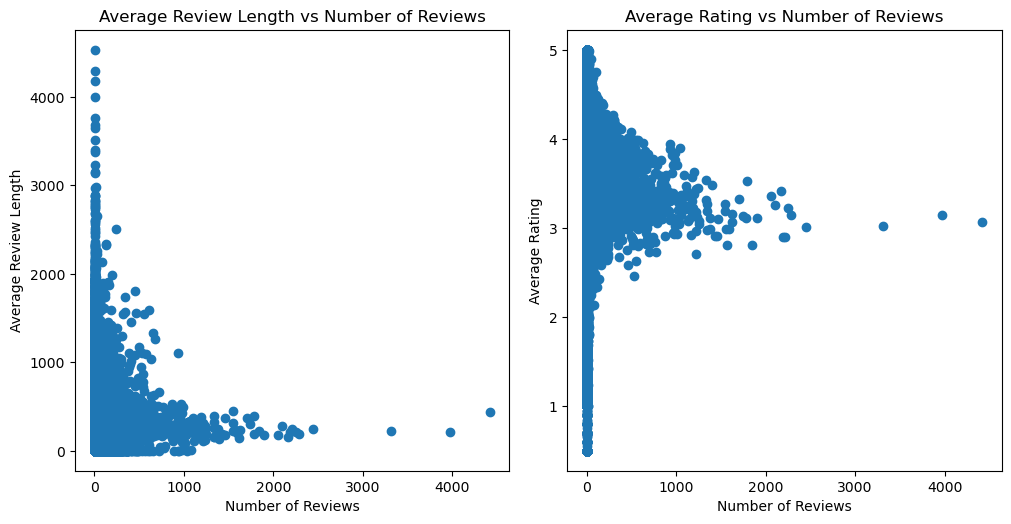

In [53]:
number_review = [user_review[user][0] for user in user_review]  # Number of Reviews
avg_review_len = [user_review[user][2] for user in user_review]  # Average Review Length
avg_rating=[user_review[user][1] for user in user_review] # Average Rating

fig,axs=plt.subplots(1,2,figsize=(10,5))
plt.tight_layout()

axs[0].scatter(number_review, avg_review_len, label='Data Points')
axs[0].set_xlabel('Number of Reviews')
axs[0].set_ylabel('Average Review Length')
axs[0].set_title('Average Review Length vs Number of Reviews')
axs[1].scatter(number_review, avg_rating, label='Data Points')
axs[1].set_xlabel('Number of Reviews')
axs[1].set_ylabel('Average Rating')
axs[1].set_title('Average Rating vs Number of Reviews')

Then, what we should do in the future is how to give a "trust" score to a user based on the analysis of his/her data